In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

### 1.

In [2]:
df = pd.read_csv('owid-covid-data.csv')

df = df[(df.location == 'Russia') & (df.date >= '2020-03-03')]
df.loc[df.new_cases == 0, 'new_cases'] = 1
df['train'] = (df.date.apply(pd.Timestamp) <= pd.Timestamp('2020-03-03')+pd.Timedelta('50 days')).astype(int)

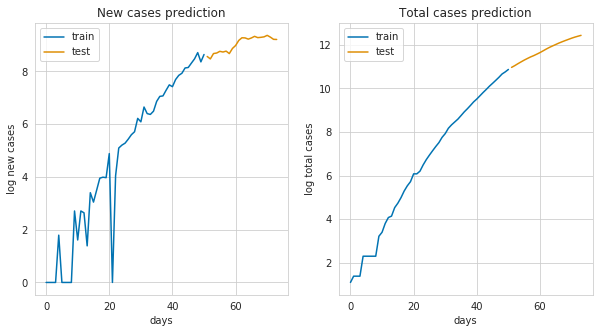

In [3]:
X_train = np.arange(np.sum(df.train))
X_train = np.vstack((np.ones(X_train.shape), X_train)).T
y_train_nc = np.log(df.loc[df.train == 1, 'new_cases'].values)
y_train_tc = np.log(df.loc[df.train == 1, 'total_cases'].values)

X_test = np.arange(np.sum(df.train), len(df))
X_test = np.vstack((np.ones(X_test.shape), X_test)).T
y_test_nc = np.log(df.loc[df.train == 0, 'new_cases'].values)
y_test_tc = np.log(df.loc[df.train == 0, 'total_cases'].values)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(X_train[:, 1], y_train_nc, label='train')
ax[0].plot(X_test[:, 1], y_test_nc, label='test')
ax[0].legend()
ax[0].set_xlabel('days')
ax[0].set_ylabel('log new cases')
ax[0].set_title('New cases prediction')

ax[1].plot(X_train[:, 1], y_train_tc, label='train')
ax[1].plot(X_test[:, 1], y_test_tc, label='test')
ax[1].legend()
ax[1].set_xlabel('days')
ax[1].set_ylabel('log total cases')
ax[1].set_title('Total cases prediction')

plt.show()

### 2. $y = e^{Xw}$

#### 2.a

Логарифмируя, получим

$\ln y = Xw$

#### 2.b

Апостериорное распределение параметров модели, считая что $p(w) = \mathscr{N}(w | 0, \frac{1}{\alpha}I)$ и обозначая через $\beta = \frac{1}{\sigma^2}$:

$p(w | t) = \mathscr{N}(w | \mu_N, \Sigma_N)$, где

$\mu_N = \beta \Sigma_N X^T \ln y$

$\Sigma_N = (\alpha I + \beta X^TX)^{-1}$

Оценим дисперсию шума в данных воспользовавшись готовыми формулами (Bishop, section 3.5.2):

$\ln p(D|\alpha, \beta) = \frac{M}{2} \ln \alpha + \frac{N}{2} \ln \beta - E(\mu_N) - \frac{1}{2} \ln(\beta X^T X + \alpha) - \frac{N}{2}\ln(2\pi)$

$\gamma = \sum_i \frac{\lambda_i}{\alpha + \lambda_i}$

$\alpha = \frac{\gamma}{\mu_N^T \mu_N}$

$\frac{1}{\beta} = \frac{1}{N-\gamma}\sum^N_{n=1}(y_n - \mu_N^T X^T)^2$

In [4]:
class FindParameters:
    def __init__(self, alpha, beta, X, y, tol=1e-5, max_iter = 1e5):
        self.alpha = alpha
        self.beta = beta
        self.old_alpha = np.inf
        self.old_beta = np.inf
        self.N, self.dim = X.shape
        self.X = X
        self.y = y
        self.tol = tol
        self.max_iter = max_iter

    def _calc_sigma(self):
        self.inv_sigma = self.alpha*np.eye(self.dim) + self.beta*self.X.T@self.X
        self.sigma = np.linalg.inv(self.inv_sigma)

    def _calc_mu(self):
        self.mu = self.beta*self.sigma@self.X.T@self.y

    def _update_gamma(self):
        self._calc_sigma()
        self._calc_mu()
        w, v = np.linalg.eig(self.beta*self.X.T@self.X)
        self.gamma = (w / (w + self.alpha)).sum()

    def _update_alpha(self):
        return self.gamma / (self.mu.T@self.mu)

    def _update_beta(self):
        return (self.N-self.gamma) / ((self.y - self.X@self.mu)**2).sum()

    def fit(self):
        i = 1
        while abs(self.alpha - self.old_alpha) > self.tol or abs(self.beta - self.old_beta) > self.tol:
            if i > self.max_iter:
                print("Didn't converged.")
                break
            i += 1
            self.old_alpha = self.alpha
            self.old_beta = self.beta
            self._update_gamma()
            self.alpha = self._update_alpha()
            self.beta = self._update_beta()
        print(f"Converged after {i} iterations.")
        return self.alpha, self.beta

In [5]:
def myplot_sample_lines(X, y, alpha, beta, n=20, pts=None, title=None):
    sigma = np.linalg.inv(alpha*np.eye(2) + beta*X.T@X)
    mu = beta*sigma@X.T@y
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    xs = np.arange(190)
    y = np.exp(np.vstack([w[0] + w[1]*xs for w in my_w]))
    xs = np.tile(xs, n)
    if title is not None:
        plt.title(title)
    sns.lineplot(xs, y.flatten())
    if pts is not None:
        for p in pts:
            plt.axvline(p, c='orange')
    plt.show()
    
    return xs, y

#### 2.b.1 New cases

In [6]:
fp = FindParameters(1, 1, X_train, y_train_nc)
alpha, beta = fp.fit()
print(alpha, beta)

Converged after 11 iterations.
37.45887242709721 1.4124524649255705


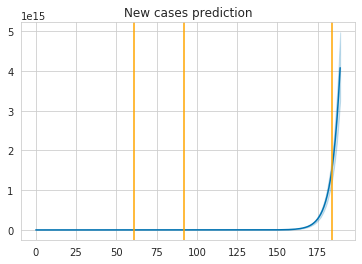

In [7]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
points = [(pd.Timestamp(d) - pd.Timestamp('2020-03-01')).days for d in dates]
x, y = myplot_sample_lines(X_train, y_train_nc, alpha, beta, 100, points, title='New cases prediction')

In [8]:
for d, p in zip(dates, points):
    print(f"For date {d} the prediction is {y.mean(0)[p]:1.0f} new cases")

For date 2020-05-01 the prediction is 97677 new cases
For date 2020-06-01 the prediction is 34890180 new cases
For date 2020-09-01 the prediction is 1555882965127489 new cases


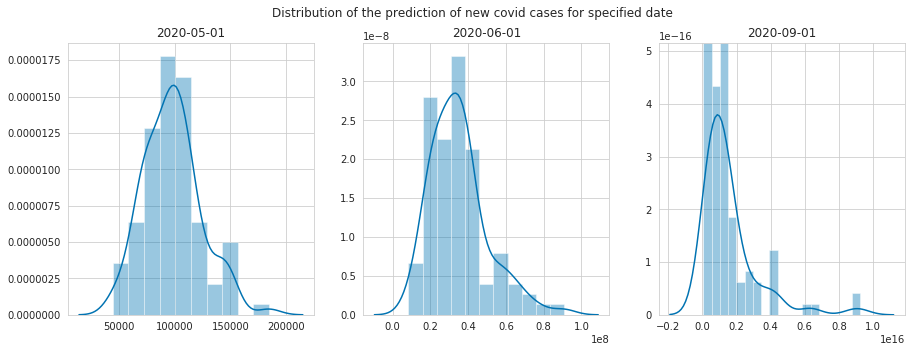

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle("Distribution of the prediction of new covid cases for specified date")
for d, p, a in zip(dates, points, ax):
    sns.distplot(y[:,p], ax=a)
    a.set_title(d)

#### 2.b.2 Total cases

In [10]:
fp = FindParameters(1, 1, X_train, y_train_tc)
alpha, beta = fp.fit()
print(alpha, beta)

Converged after 6 iterations.
0.8766976023190184 7.013191017857812


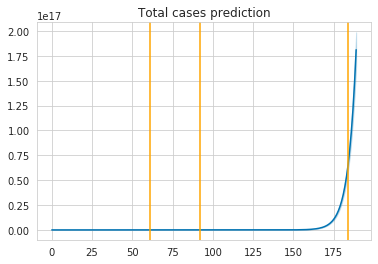

In [11]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
points = [(pd.Timestamp(d) - pd.Timestamp('2020-03-01')).days for d in dates]
x, y = myplot_sample_lines(X_train, y_train_tc, alpha, beta, 100, points, title='Total cases prediction')

In [12]:
for d, p in zip(dates, points):
    print(f"For date {d} the prediction is {y.mean(0)[p]:1.0f} total cases")

For date 2020-05-01 the prediction is 995058 total cases
For date 2020-06-01 the prediction is 523849771 total cases
For date 2020-09-01 the prediction is 65642390857805472 total cases


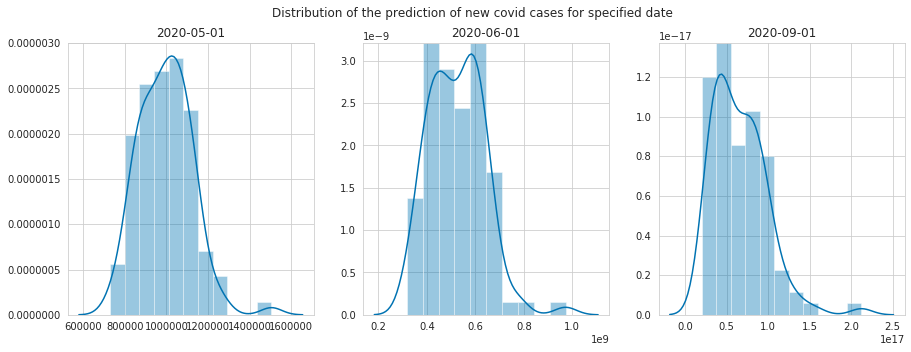

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle("Distribution of the prediction of new covid cases for specified date")
for d, p, a in zip(dates, points, ax):
    sns.distplot(y[:,p], ax=a)
    a.set_title(d)

### 3. $y = \Phi(Xw)$

#### 3.a

$y = \frac{1}{2\pi} \int_{-\infty}^x e^{-\frac{t^2}{2}} dt = e^{a} \int_{-\infty}^x e^{c t^2 + b t} dt$

Дифференцируя и логарифмируя, получим

$\frac{d}{dx} y = e^{c x^2 + b x + a} = e^{Xw}, c \le 0$

$\ln \frac{d}{dx} y = c x^2 + b x + a = Xw$

In [14]:
def ln_dx(y):
    y_der = (y[2:] - y[:-2]) / 2
    y_der = np.hstack([[y[1] - y[0]], y_der, [y[-1] - y[-2]]])
    y_der = np.where(y_der == 0, 1, y_der)
    return np.log(y_der)

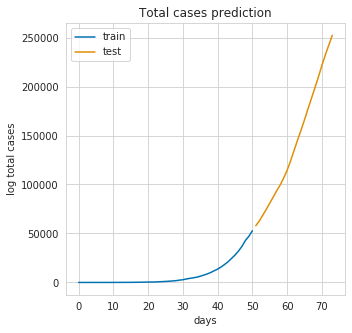

In [15]:
X_train = np.arange(np.sum(df.train))
X_train = np.vstack((np.ones(X_train.shape), X_train, X_train**2)).T
y_train_tc = df.loc[df.train == 1, 'total_cases'].values

X_test = np.arange(np.sum(df.train), len(df))
X_test = np.vstack((np.ones(X_test.shape), X_test, X_test**2)).T
y_test_tc =df.loc[df.train == 0, 'total_cases'].values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(X_train[:, 1], y_train_tc, label='train')
ax.plot(X_test[:, 1], y_test_tc, label='test')
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('log total cases')
ax.set_title('Total cases prediction')

plt.show()

In [16]:
X_train = np.arange(np.sum(df.train))
X_train = np.vstack((np.ones(X_train.shape), X_train, X_train**2)).T
y_train_tc = ln_dx(df.loc[df.train == 1, 'total_cases'].values)

X_test = np.arange(np.sum(df.train), len(df))
X_test = np.vstack((np.ones(X_test.shape), X_test, X_test**2)).T
y_test_tc = ln_dx(df.loc[df.train == 0, 'total_cases'].values)

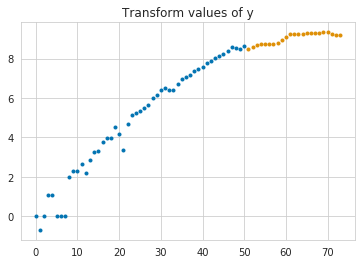

In [17]:
plt.plot(X_train[:, 1], y_train_tc, '.')
plt.plot(X_test[:, 1], y_test_tc, '.')
plt.title('Transform values of y')
plt.show()

#### 3.b Аналогично пунтку 2.

Апостериорное распределение параметров модели, считая что $p(w) = \mathscr{N}(w | 0, \frac{1}{\alpha}I)$ и обозначая через $\beta = \frac{1}{\sigma^2}$:

$p(w | t) = \mathscr{N}(w | \mu_N, \Sigma_N)$, где

$\mu_N = \beta \Sigma_N X^T \ln y$

$\Sigma_N = (\alpha I + \beta X^TX)^{-1}$

Оценим дисперсию шума в данных воспользовавшись готовыми формулами (Bishop, section 3.5.2):

$\ln p(D|\alpha, \beta) = \frac{M}{2} \ln \alpha + \frac{N}{2} \ln \beta - E(\mu_N) - \frac{1}{2} \ln(\beta X^T X + \alpha) - \frac{N}{2}\ln(2\pi)$

$\gamma = \sum_i \frac{\lambda_i}{\alpha + \lambda_i}$

$\alpha = \frac{\gamma}{\mu_N^T \mu_N}$

$\frac{1}{\beta} = \frac{1}{N-\gamma}\sum^N_{n=1}(y_n - \mu_N^T X^T)^2$

In [18]:
def integrand(t, a, b, c):
    return np.exp(c * t**2 + b * t + a)

def phi(x, a, b, c):
    return integrate.quad(integrand, -np.inf, x, args=(a, b, c))[0]

phi_vec = np.vectorize(phi, excluded=['a', 'b', 'c'])

def myplot_sample_lines(X, y, alpha, beta, n=20, pts=None, title=None):
    sigma = np.linalg.inv(alpha*np.eye(3) + beta*X.T@X)
    mu = beta*sigma@X.T@y
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    xs = np.arange(190)
    y = np.vstack([phi_vec(xs, *w) for w in my_w])
    xs = np.tile(xs, n)
    if title is not None:
        plt.title(title)
    sns.lineplot(xs, y.flatten())
    if pts is not None:
        for p in pts:
            plt.axvline(p, c='orange')
    plt.show()
    
    return xs, y

#### 3.b Total cases

In [19]:
fp = FindParameters(1, 1, X_train, y_train_tc)
alpha, beta = fp.fit()
print(alpha, beta)

Converged after 13 iterations.
10.380594503292992 6.034223285703665


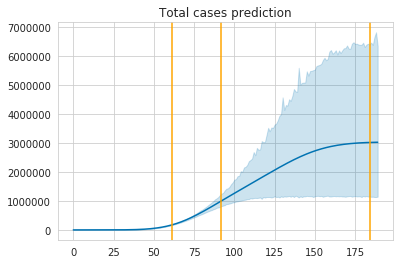

In [20]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
points = [(pd.Timestamp(d) - pd.Timestamp('2020-03-01')).days for d in dates]
x, y = myplot_sample_lines(X_train, y_train_tc, alpha, beta, 100, points, title='Total cases prediction')

In [21]:
for d, p in zip(dates, points):
    true_tc = df.loc[df.date == d, 'total_cases'].values[0] if d in df.date.values else 'N/A'
    print(f'''For date {d} worst scenario: {np.percentile(y[:, p], 90):1.0f} total cases
                    best scenario: {np.percentile(y[:, p], 10):1.0f} total cases
                    really happend {true_tc}''')

For date 2020-05-01 worst scenario: 207462 total cases
                    best scenario: 134058 total cases
                    really happend 106498
For date 2020-06-01 worst scenario: 1788326 total cases
                    best scenario: 375603 total cases
                    really happend N/A
For date 2020-09-01 worst scenario: 3178580 total cases
                    best scenario: 396202 total cases
                    really happend N/A


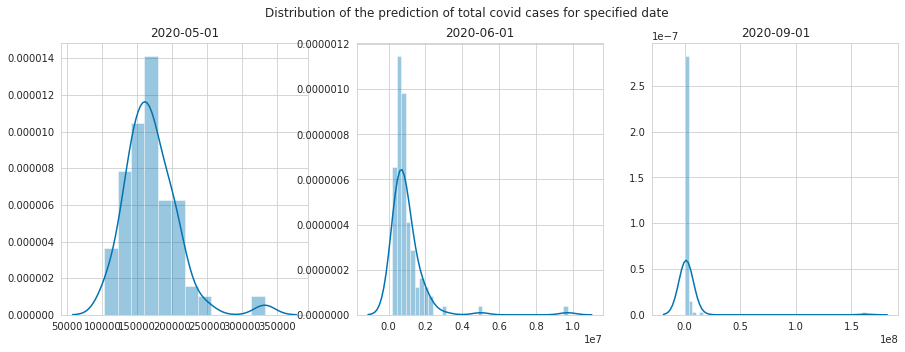

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle("Distribution of the prediction of total covid cases for specified date")
for d, p, a in zip(dates, points, ax):
    sns.distplot(y[:,p], ax=a)
    a.set_title(d)

### United States

In [23]:
df = pd.read_csv('owid-covid-data.csv')

df = df[(df.location == 'United States') & (df.date >= '2020-02-27')]
df.loc[df.new_cases == 0, 'new_cases'] = 1
df['train'] = (df.date.apply(pd.Timestamp) <= pd.Timestamp('2020-02-27')+pd.Timedelta('60 days')).astype(int)

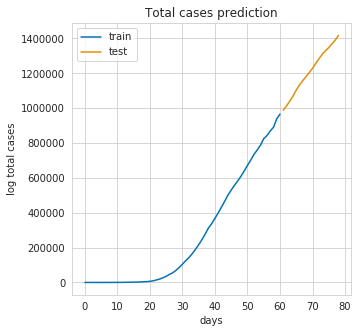

In [24]:
X_train = np.arange(np.sum(df.train))
X_train = np.vstack((np.ones(X_train.shape), X_train)).T
y_train_tc = df.loc[df.train == 1, 'total_cases'].values

X_test = np.arange(np.sum(df.train), len(df))
X_test = np.vstack((np.ones(X_test.shape), X_test)).T
y_test_tc = df.loc[df.train == 0, 'total_cases'].values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(X_train[:, 1], y_train_tc, label='train')
ax.plot(X_test[:, 1], y_test_tc, label='test')
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('log total cases')
ax.set_title('Total cases prediction')

plt.show()

In [25]:
X_train = np.arange(np.sum(df.train))
X_train = np.vstack((np.ones(X_train.shape), X_train, X_train**2)).T
y_train_tc = ln_dx(df.loc[df.train == 1, 'total_cases'].values)

X_test = np.arange(np.sum(df.train), len(df))
X_test = np.vstack((np.ones(X_test.shape), X_test, X_test**2)).T
y_test_tc = ln_dx(df.loc[df.train == 0, 'total_cases'].values)

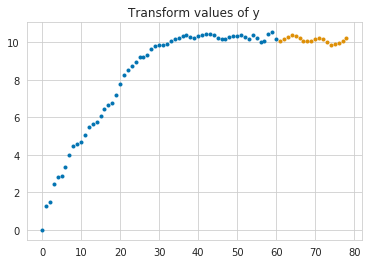

In [26]:
plt.plot(X_train[:, 1], y_train_tc, '.')
plt.plot(X_test[:, 1], y_test_tc, '.')
plt.title('Transform values of y')
plt.show()

#### 3.b Total cases

In [27]:
fp = FindParameters(1, 1, X_train, y_train_tc)
alpha, beta = fp.fit()
print(alpha, beta)

Converged after 7 iterations.
3.1195137597981772 9.80706568821596


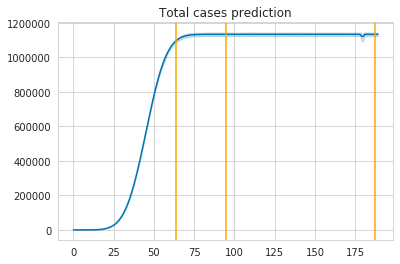

In [28]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
points = [(pd.Timestamp(d) - pd.Timestamp('2020-02-27')).days for d in dates]
x, y = myplot_sample_lines(X_train, y_train_tc, alpha, beta, 100, points, title='Total cases prediction')

In [29]:
for d, p in zip(dates, points):
    true_tc = df.loc[df.date == d, 'total_cases'].values[0] if d in df.date.values else 'N/A'
    print(f'''For date {d} worst scenario: {np.percentile(y[:, p], 90):1.0f} total cases
                    best scenario: {np.percentile(y[:, p], 10):1.0f} total cases
                    really happend {true_tc}''')

For date 2020-05-01 worst scenario: 1171489 total cases
                    best scenario: 1027947 total cases
                    really happend 1069826
For date 2020-06-01 worst scenario: 1213234 total cases
                    best scenario: 1059276 total cases
                    really happend N/A
For date 2020-09-01 worst scenario: 1213235 total cases
                    best scenario: 1059277 total cases
                    really happend N/A


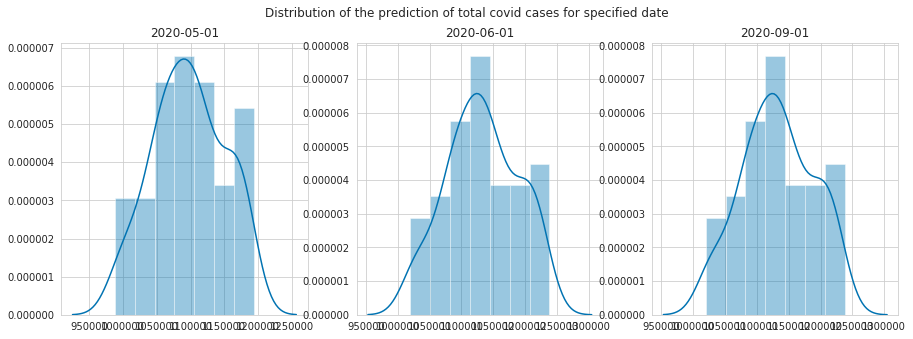

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle("Distribution of the prediction of total covid cases for specified date")
for d, p, a in zip(dates, points, ax):
    sns.distplot(y[:,p], ax=a)
    a.set_title(d)